In [53]:
# =========================
# Imports & Setup
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
import missingno as msno
import re
from warnings import filterwarnings
filterwarnings("ignore")

df = pd.read_csv("Divar.csv", index_col=0)

# =========================
# Helper Functions
# =========================
def fa_to_en_digits(s):
    if pd.isna(s):
        return s
    persian = "۰۱۲۳۴۵۶۷۸۹"
    english = "0123456789"
    return s.translate(str.maketrans(persian, english))

def arabic_to_int(s):
    arabic_digits = {"٠":0 , "١":1 , "٢":2 , "٣":3 , "٤":4 , "٥":5 , "٦":6 , "٧":7 , "٨":8 , "٩":9}
    return int("".join(str(arabic_digits.get(ch , ch)) for ch in s))

def time_to_index(series):
    result = ((series.dt.year - 2020) * 4 + ((series.dt.month - 1) // 3 + 1))
    result[series.dt.year < 2020] = 0
    return result

# ---- extractors (همون منطق خودت) ----
def extract_building_size(text):
    if pd.isna(text):
        return np.nan
    text = fa_to_en_digits(text)
    matches = re.findall(r'(\d+)\s*(?:متر(?:ی|مربع)?|m)', text, flags=re.IGNORECASE)
    if not matches:
        return np.nan
    nums = [int(m) for m in matches]
    return nums[0]

def extract_building_from_title(text):
    if pd.isna(text):
        return np.nan
    text = fa_to_en_digits(text)
    matches = re.findall(r'(\d+)\s*(?:متر(?:ی|مربع)?|m)', text, flags=re.IGNORECASE)
    if not matches:
        return np.nan
    nums = [int(m) for m in matches]
    return nums[0]

persian_to_num = {
    "اول": 1, "دوم": 2, "سوم": 3, "چهارم": 4, "پنجم": 5,
    "ششم": 6, "هفتم": 7, "هشتم": 8, "نهم": 9, "دهم": 10,
    "همکف": 0, "زیرزمین": -1, "آخر": np.nan
}

def extract_floor(text):
    if pd.isna(text):
        return np.nan
    text = fa_to_en_digits(text)
    m1 = re.search(r'طبقه\s*(\d+)', text)
    if m1: return int(m1.group(1))
    m2 = re.search(r'(\d+)\s*طبقه', text)
    if m2: return int(m2.group(1))
    for k, v in persian_to_num.items():
        if f"طبقه {k}" in text or f"{k} طبقه" in text:
            return v
    return np.nan

_persian_digits_tbl = str.maketrans("۰۱۲۳۴۵۶۷۸۹", "0123456789")
_num_words = {"یک":1,"دو":2,"سه":3,"چهار":4,"پنج":5,"شش":6,"هفت":7,"هشت":8,"نه":9,"ده":10}

def extract_rooms(text):
    if pd.isna(text):
        return np.nan
    text = str(text).translate(_persian_digits_tbl)
    m = re.search(r"(\d+)\s*خواب", text) or re.search(r"(\d+)\s*خوابه", text) or re.search(r"(\d+)\s*اتاق(?:ه)?", text)
    if m: return int(m.group(1))
    for w, n in _num_words.items():
        if re.search(fr"{w}\s*(?:خواب|خوابه|اتاق|اتاقه)", text):
            return n
    if "بدون اتاق" in text or "سوئیت" in text:
        return 0
    return np.nan

def extract_balcony(text):
    if pd.isna(text):
        return np.nan
    text = str(text)
    if re.search(r"(بالکن|تراس|ایوان)", text):
        return True
    return np.nan

def extract_feature(text, positive_keywords, negative_keywords):
    if pd.isna(text):
        return np.nan
    text = str(text)
    if any(re.search(pat, text) for pat in negative_keywords):
        return False
    if any(re.search(pat, text) for pat in positive_keywords):
        return True
    return np.nan

def fill_boolean_feature(df, col_name, positive_keywords, negative_keywords):
    from_title = df["title"].apply(lambda x: extract_feature(x, positive_keywords, negative_keywords))
    from_text  = from_title.fillna(df["description"].apply(lambda x: extract_feature(x, positive_keywords, negative_keywords)))
    df[col_name] = df[col_name].fillna(from_text)
    return df

# جدول نال/دی‌تایپ که در کدت صدا زده بودی
def get_table_null_dtype(_df: pd.DataFrame):
    out = pd.DataFrame({
        "column": _df.columns,
        "null_count": _df.isna().sum().values,
        "null_percentage": (_df.isna().mean().values * 100),
        "dtype": _df.dtypes.astype(str).values,
    })
    return out.sort_values("null_percentage", ascending=False).reset_index(drop=True)

In [54]:
# =========================
# Category Lists (قبل از استفاده در cleaning)
# =========================
necessary_options = ["has_water" , "has_electricity" , "has_gas"]
lux_options       = ["has_barbecue" , "has_pool" , "has_jacuzzi" , "has_sauna" , "has_security_guard"]
normal_options    = ["has_balcony" , "has_elevator" , "has_warehouse" , "has_parking" ,
                     "has_warm_water_provider" , "has_heating_system" , "is_rebuilt" , "has_cooling_system" , 
                     "has_restroom"]

for_sale = ["residential-sell" , "commercial-sell"]
for_rent = ["residential-rent" , "commercial-rent" , "temporary-rent"]

residential = ["residential-sell" , "residential-rent" , "temporary-rent"]
commercial  = ["commercial-rent" , "commercial-sell"]

rent_related  = ["rent_value" , "rent_type" , "rent_credit_transform" , "credit_value" ,
                 "transformable_credit" , "transformed_credit" , "transformable_rent" , "transformed_rent"]
price_related = ["price_value" , "transformable_price"]

# =========================
# Load Data
# =========================

print("Number of Rows =", df.shape[0])
print("Number of Columns =", df.shape[1])

# =========================
# Feature Extraction (قبل از حذف title/description)
# =========================
# building_size از متن و عنوان
df["building_size_extracted"]   = df["description"].apply(extract_building_size)
df["building_size_from_title"]  = df["title"].apply(extract_building_from_title)
df["building_size_final"]       = df["building_size"].fillna(df["building_size_extracted"])
df["building_size_final"]       = df["building_size_final"].fillna(df["building_size_from_title"])

# floor از متن و عنوان + نرمال‌سازی عددی
df["floor_extracted"]        = df["description"].apply(extract_floor)
df["floor_extracted_title"]  = df["title"].apply(extract_floor)
df["floor_final"]            = df["floor"].fillna(df["floor_extracted"])
df["floor_final"]            = df["floor_final"].fillna(df["floor_extracted_title"])
df["floor"]                  = pd.to_numeric(df["floor"], errors="coerce")

# rooms از عنوان و متن
df["rooms_from_title"] = df["title"].apply(extract_rooms)
df["rooms_from_text"]  = df["rooms_from_title"].fillna(df["description"].apply(extract_rooms))
df["rooms_count"]      = df["rooms_count"].fillna(df["rooms_from_text"])

# balcony از عنوان و متن
df["balcony_from_title"] = df["title"].apply(extract_balcony)
df["balcony_from_text"]  = df["balcony_from_title"].fillna(df["description"].apply(extract_balcony))
df["has_balcony"]        = df["has_balcony"].fillna(df["balcony_from_text"])

# آسانسور/پارکینگ/انباری/بازسازی با الگوها
df = fill_boolean_feature(df, "has_elevator",
                          positive_keywords=[r"آسانسور", r"اسانسور"],
                          negative_keywords=[r"بدون آسانسور", r"آسانسور ندارد"])

df = fill_boolean_feature(df, "has_parking",
                          positive_keywords=[r"پارکینگ", r"گاراژ", r"جای پارک"],
                          negative_keywords=[r"بدون پارکینگ", r"پارکینگ ندارد", r"فاقد پارکینگ"])

df = fill_boolean_feature(df, "has_warehouse",
                          positive_keywords=[r"انباری", r"انبار"],
                          negative_keywords=[r"بدون انباری", r"انبار ندارد"])

df = fill_boolean_feature(df, "is_rebuilt",
                          positive_keywords=[r"بازسازی شده", r"بازسازی کامل", r"نوسازی", r"تعمیر اساسی", r"renovation"],
                          negative_keywords=[r"نیاز به بازسازی", r"بازسازی نشده", r"قدیمی"])

# اگر floor هنوز خالی بود، میانه‌ی هر cat3_slug را جایگزین کن (منطق خودت با اصلاح تایپی)
df = df.dropna(subset=['cat3_slug'])
median_floors = df.groupby('cat3_slug')['floor'].median()
median_dict   = median_floors.to_dict()
df["floor_final"] = df.apply(lambda row: median_dict.get(row["cat3_slug"], np.nan) if pd.isna(row["floor"]) else row["floor"], axis=1)

Number of Rows = 1000000
Number of Columns = 60


In [55]:
# =========================
# Cleaning & Encoding (ستون‌به‌ستون طبق کدت)
# =========================
# column 00
# df = df.drop("cat2_slug" , axis = 1)
df = df.dropna(subset = ["cat2_slug"])
df = df.loc[df["cat2_slug"] != "real-estate-services"]

# column 01
df = df.dropna(subset = ["cat3_slug"])

# column 02
df = df.dropna(subset = ["city_slug"])

# column 03
# df = df.drop("neighborhood_slug" , axis = 1)

# column 04
df = df.dropna(subset = ["created_at_month"])
df["created_at_month"] = pd.to_datetime(df["created_at_month"])
df["created_at_month"] = time_to_index(df["created_at_month"])

# column 05
df["user_type"] = df["user_type"].eq("مشاور املاک")

# column 06/07 (حذف متن/عنوان پس از استخراج ویژگی‌ها)
df = df.drop("description" , axis = 1)
df = df.drop("title" , axis = 1)

# column 08
df["rent_mode"] = df["rent_mode"].eq("مقطوع")

# column 10
df = df.drop("rent_to_single" , axis = 1)

# column 12
df["price_mode"] = df["price_mode"].eq("مقطوع")

# column 14
df["credit_mode"] = df["credit_mode"].eq("مقطوع")

# column 22
df = df.drop("land_size" , axis = 1)

# column 23
group_means = df.groupby("neighborhood_slug")["building_size"].transform("mean")
df["building_size"] = df["building_size"].fillna(group_means)
df = df.dropna(subset = ["building_size"])

# column 24
df["deed_type"] = df["deed_type"].isin(["written_agreement" , "multi_page" , "other"])

# column 25
df["has_business_deed"] = df["has_business_deed"].isin(["True" , True])

# column 26
df["floor"] = df["floor"].replace("30+" , 30).astype(float)

# column 27
df = df.dropna(subset = ["rooms_count"])
df["rooms_count"] = df["rooms_count"].replace({"دو":2 , "یک":1 , "سه":3 , "بدون اتاق":0 , "چهار":4 , "پنج یا بیشتر":5})

# column 28
df["total_floors_count"] = df["total_floors_count"].replace("30+" , 30)
df["total_floors_count"] = df["total_floors_count"].replace("unselect" , np.nan)
df.loc[df["cat3_slug"].isin(["house-villa-sell" , "house-villa-rent" , "villa"]) , "total_floors_count"] = 0
df["total_floors_count"] = df["total_floors_count"].astype(float)
df["total_floors_count"] = np.where(df["total_floors_count"] > 10 , 2 ,
                                    np.where(df["total_floors_count"].between(5 , 10) , 1 , 0))

# column 29
df = df.drop("unit_per_floor" , axis = 1)

# column 30..33
df["has_balcony"]   = df["has_balcony"].isin([True , "true"])
df["has_elevator"]  = df["has_elevator"].eq(True)
df["has_warehouse"] = df["has_warehouse"].eq(True)
df["has_parking"]   = df["has_parking"].eq(True)

# column 34
df["construction_year"] = df["construction_year"].replace("قبل از ۱۳۷۰" , "۱۳۷۰")
df["construction_year"] = df["construction_year"].fillna("۰")
df["construction_year"] = df["construction_year"].apply(arabic_to_int)
df["construction_year"] = df["construction_year"].replace(0 , np.nan)
df = df.dropna(subset = ["construction_year"])
df["construction_year"] = 1404 - df["construction_year"]
df["construction_year"] = df["construction_year"].astype(int)

# column 35
df["is_rebuilt"] = df["is_rebuilt"].eq(True)

# column 36,38,39
for necessary_option in necessary_options:
    df[necessary_option] = ~df[necessary_option].eq(False)
del necessary_option

# column 37
df["has_warm_water_provider"] = df["has_warm_water_provider"].eq("package")

# column 40
df["has_heating_system"] = df["has_heating_system"].eq("shoofaj")

# column 41
df["has_cooling_system"] = df["has_cooling_system"].isin(["air_conditioner" , "split"])

# column 42
df["has_restroom"] = df["has_restroom"].isin(["squat_seat" , "seat"])

# column 43
df["has_security_guard"] = df["has_security_guard"].isin([True])

# columns 44,46,47,48
for lux_option in lux_options:
    df[lux_option] = df[lux_option].eq(True)
del lux_option

# column 45
df = df.drop("building_direction" , axis = 1)

# column 49
df["floor_material"] = df["floor_material"].isin(["stone" , "carpet" , "wood_parquet" , "laminate_parquet"])

# column 50
df["property_type"] = ~df["property_type"].isna()

# column 51
df["regular_person_capacity"] = df["regular_person_capacity"] > 10

In [56]:
# column 52
df["extra_person_capacity"] = df["extra_person_capacity"].replace("30+" , 30).astype(float) > 5

# column 53..56
df = df.drop("cost_per_extra_person" , axis = 1)
df = df.drop("rent_price_on_regular_days" , axis = 1)
df = df.drop("rent_price_on_special_days" , axis = 1)
df = df.drop("rent_price_at_weekends" , axis = 1)

# column 57
group_means = df.groupby("neighborhood_slug")["location_latitude"].transform("mean")
df["location_latitude"] = df["location_latitude"].fillna(group_means)
df = df.dropna(subset = ["location_latitude"])

# column 58
group_means = df.groupby("neighborhood_slug")["location_longitude"].transform("mean")
df["location_longitude"] = df["location_longitude"].fillna(group_means)
df = df.dropna(subset = ["location_longitude"])

# column 59
df = df.drop("location_radius" , axis = 1)

# add new columns 
df["lux_count"]       = df.loc[:, lux_options].sum(axis = 1)
df["necessary_count"] = df.loc[:, necessary_options].sum(axis = 1)
df["normal_count"]    = df.loc[:, normal_options].sum(axis = 1)

df["mode_rent"] = df["rent_mode"].astype(int) + df["credit_mode"].astype(int)
df["mode_sale"] = df["price_mode"].astype(int)
df["mode"] = np.where(
    df["cat2_slug"].isin(for_sale), df["mode_sale"],
    np.where(df["cat2_slug"].isin(for_rent), df["mode_rent"], np.nan)
)
df = df.drop(["mode_rent" , "rent_mode" , "credit_mode" , "mode_sale" , "price_mode"] , axis = 1)
df["mode"] = df["mode"].astype(int)

# =========================
# Drops that you listed later (بدون تغییر در منطق)
# =========================
df = df.drop(['building_size' , 'floor' , 'rooms_count' , 'rooms_from_text' , 'rooms_from_title' ,
              'balcony_from_title' , 'balcony_from_text' , 'floor_extracted' , 'floor_extracted'] , axis = 1)
df = df.drop(['floor_extracted_title' , 'building_size_from_title' , 'building_size_extracted'] , axis = 1)

# =========================
# Target (Y) & final reports
# =========================
df["for_sale"] = df["cat2_slug"].isin(for_sale)
df["Y"] = np.where(df["for_sale"] == True , df["price_value"] , df["transformable_credit"])
df = df.drop(price_related , axis = 1)
df = df.drop(rent_related  , axis = 1)
df["Y"] = df["Y"].astype(float)
df = df.dropna(subset = ["Y"])

print("Number of Rows =" , df.shape[0])
print("Number of Columns =" , df.shape[1])

table = get_table_null_dtype(df)
# مثل کدت:
table[table["null_percentage"] > 0]
table[table["dtype"] == "object"]
get_table_null_dtype(df)

Number of Rows = 660623
Number of Columns = 41


,column,null_count,null_percentage,dtype
0,neighborhood_slug,272571,41.25969,object
1,floor_final,190714,28.86881,float64
2,cat2_slug,0,0.00000,object
3,extra_person_capacity,0,0.00000,bool
4,has_barbecue,0,0.00000,bool
5,has_pool,0,0.00000,bool
6,has_jacuzzi,0,0.00000,bool
7,has_sauna,0,0.00000,bool
8,floor_material,0,0.00000,bool
9,property_type,0,0.00000,bool


### Sanam

In [ ]:
#UTM
from pyproj import Proj, transform

df_cluster = df.dropna(subset=['location_latitude', 'location_longitude', 'Y']).copy()
df_cluster = df_cluster.sample(n=5000, random_state=42) if len(df_cluster) > 5000 else df_cluster

in_proj = Proj(init='epsg:4326')
out_proj = Proj(init='epsg:32639') 

# Apply the conversion
df_cluster['utm_easting'], df_cluster['utm_northing'] = transform(
    in_proj,
    out_proj,
    df_cluster['location_longitude'].values,
    df_cluster['location_latitude'].values
)

features = df_cluster[['utm_easting', 'utm_northing', 'Y']]


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=20)
clusters = dbscan.fit_predict(scaled_features)

for eps in np.arange(0.1, 2.0, 0.01):
    db = DBSCAN(eps=eps, min_samples=20)
    clusters = db.fit_predict(scaled_features)
    n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
    
    if n_clusters == 3:
        print(f"3 clusters with eps = {eps}")
        df_cluster['cluster'] = clusters
        break

df_cluster['dbscan_cluster'] = clusters

# Check the number of clusters found (-1 is noise)
n_clusters_ = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise_ = list(clusters).count(-1)

print(f"Number of clusters found by DBSCAN: {n_clusters_}")
print(f"Number of noise points: {n_noise_}")

✅ Found 3 clusters with eps = 0.5199999999999998
Number of clusters found by DBSCAN: 3
Number of noise points: 54


In [84]:
df_cluster['cluster'].value_counts()

cluster
 0    4332
 1     505
 2     109
-1      54
Name: count, dtype: int64

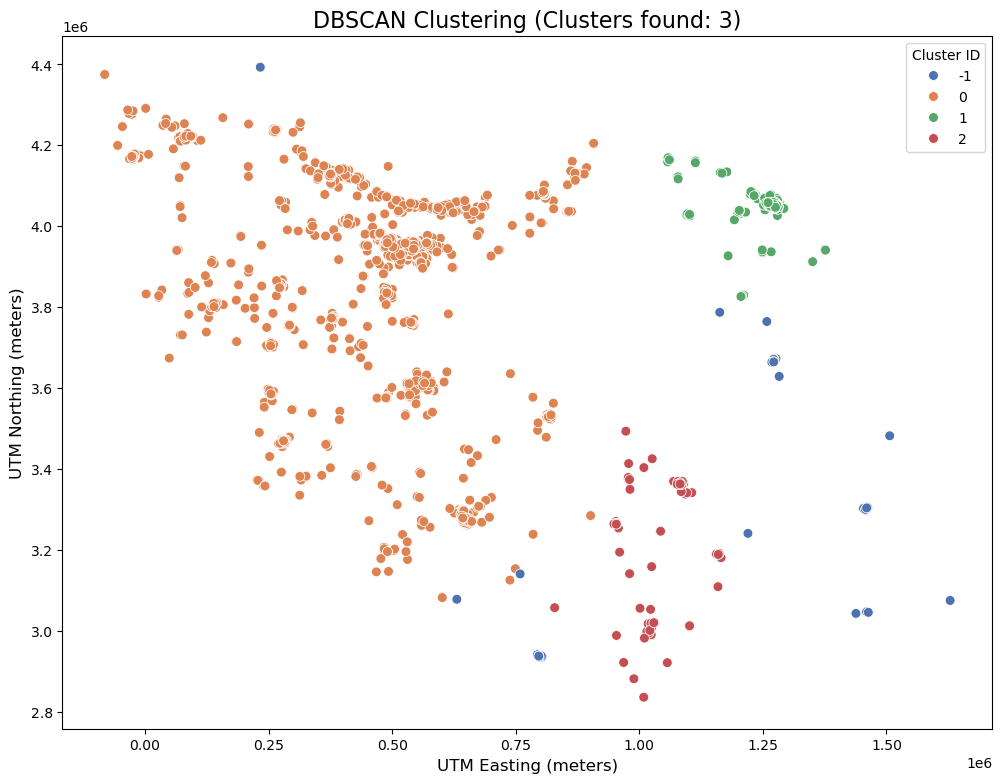

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 9))
sns.scatterplot(
    x='utm_easting',
    y='utm_northing',
    hue='dbscan_cluster',
    data=df_cluster,
    palette='deep',
    s=50
)
plt.title(f'DBSCAN Clustering (Clusters found: {n_clusters_})', fontsize=16)
plt.xlabel('UTM Easting (meters)', fontsize=12)
plt.ylabel('UTM Northing (meters)', fontsize=12)
plt.legend(title='Cluster ID')
plt.show()


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

X_full = df_cluster[['utm_easting', 'utm_northing']]
mask_noise = df_cluster['cluster'] == -1
mask_clustered = df_cluster['cluster'] != -1

X_train = X_full[mask_clustered]
y_train = df_cluster.loc[mask_clustered, 'cluster']

X_noise = X_full[mask_noise]

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

predicted_labels = knn.predict(X_noise)

df_cluster.loc[mask_noise, 'cluster'] = predicted_labels


In [ ]:
df_cluster['cluster'].value_counts()

cluster
0    4338
1     519
2     143
Name: count, dtype: int64

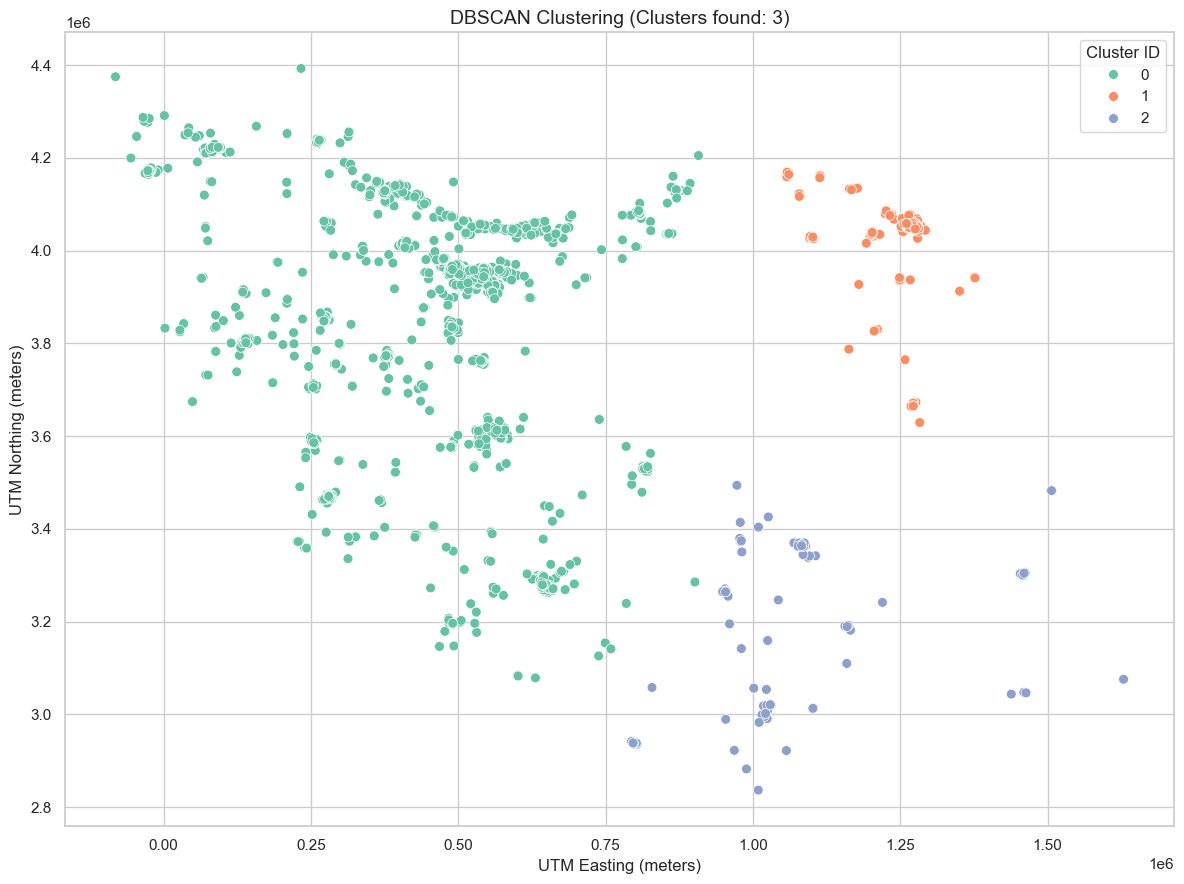

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 9))
sns.set(style="whitegrid")

sns.scatterplot(
    data=df_cluster,
    x='utm_easting',
    y='utm_northing',
    hue='cluster',
    palette='Set2',
    s=50,
    edgecolor='white',
    linewidth=0.5
)

plt.title(f"DBSCAN Clustering (Clusters found: {df_cluster['cluster'].nunique()})", fontsize=14)
plt.xlabel("UTM Easting (meters)")
plt.ylabel("UTM Northing (meters)")
plt.legend(title="Cluster ID", loc='upper right')
plt.tight_layout()
plt.show()


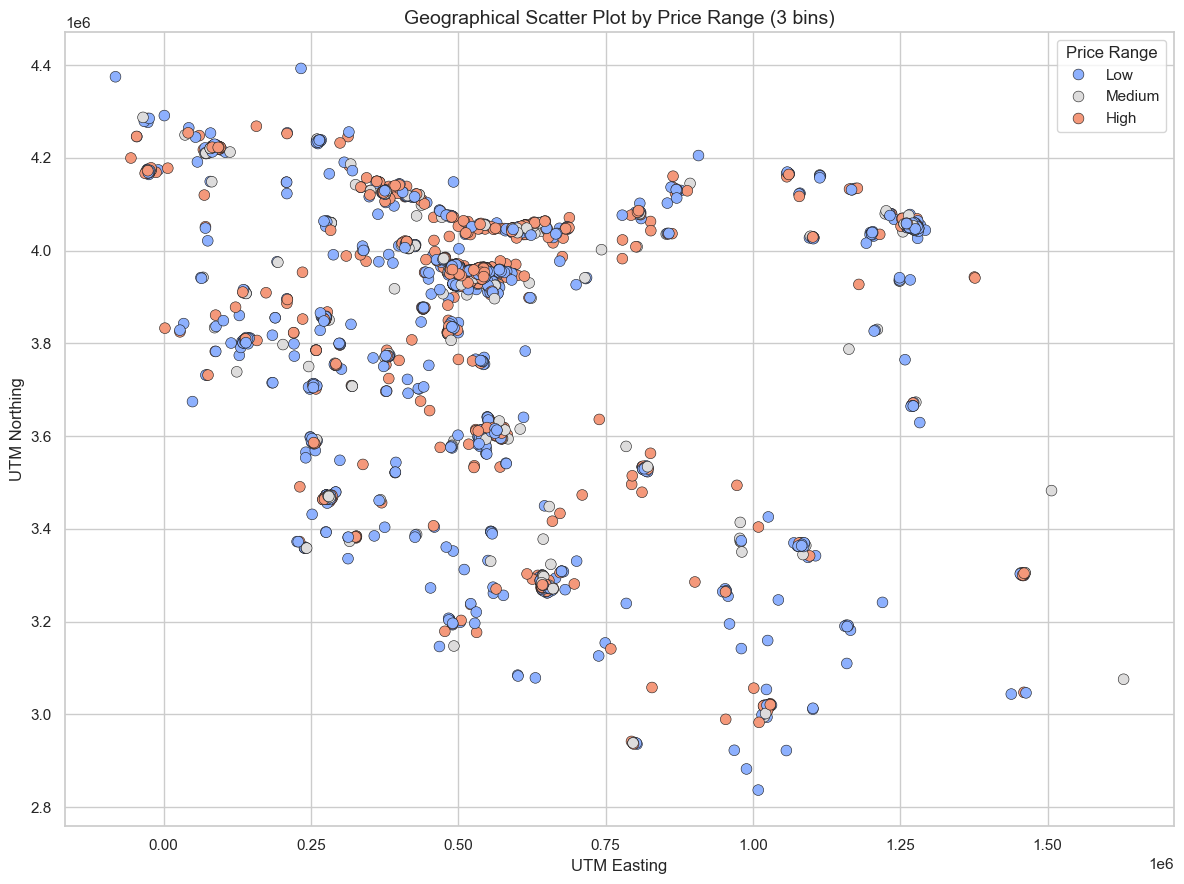

In [ ]:
bins = [0, 1_000_000_000, 2_000_000_000, float('inf')]
labels = ['Low', 'Medium', 'High']

df_cluster['price_range'] = pd.cut(df_cluster['Y'], bins=bins, labels=labels)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 9))
sns.set(style="whitegrid")

# Create the scatter plot
sns.scatterplot(
    data=df_cluster,
    x='utm_easting',
    y='utm_northing',
    hue='price_range',       
    palette='coolwarm',
    s=60,
    edgecolor='k',
    linewidth=0.4
)

plt.title("Geographical Scatter Plot by Price Range (3 bins)", fontsize=14)
plt.xlabel("UTM Easting")
plt.ylabel("UTM Northing")
plt.legend(title='Price Range')
plt.tight_layout()
plt.show()